### PROBLEM STATEMENT

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

    Demographics (city, age, gender etc.)
    Tenure information (joining date, Last Date)
    Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,f_oneway,chi2_contingency,shapiro,norm,kstest,ttest_ind
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

### IMPORT DATASET

In [2]:
df=pd.read_csv(r"C:\Users\gokul\OneDrive\Desktop\SCALER\OLA\ola_driver_scaler.csv")

### DATA EXPLORATION

In [3]:
#First 5 rows#

df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


**MMMM-YY** : Reporting Date (Monthly)<br>
**Driver_ID** : Unique id for drivers<br>
**Age** : Age of the driver<br>
**Gender** : Gender of the driver – Male : 0, Female: 1<br>
**City** : City Code of the driver<br>
**Education_Level** : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate<br>
**Income** : Monthly average Income of the driver<br>
**Date Of Joining** : Joining date for the driver<br>
**LastWorkingDate** : Last date of working for the driver<br>
**Joining Designation** : Designation of the driver at the time of joining<br>
**Grade** : Grade of the driver at the time of reporting<br>
**Total Business Value** : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)<br>
**Quarterly Rating** : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [4]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [6]:
df.shape

(19104, 13)

There are around 19100 data points and 13 features in the dataset

In [14]:
#Info on datatypes of features, count of non null data points#

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  object        
 2   Age                   19043 non-null  float64       
 3   Gender                19104 non-null  object        
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  object        
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  object        
 10  Grade                 19104 non-null  object        
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  object        
dtypes: datetime64[ns

In [15]:
#Data type conversions

df['MMM-YY']=pd.to_datetime(df['MMM-YY'])
df['Driver_ID']=df['Driver_ID'].astype('str')
df['Gender']=df['Gender'].astype('str')
df['Education_Level']=df['Education_Level'].astype('str')
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'])
df['Joining Designation']=df['Joining Designation'].astype('str')
df['Grade']=df['Grade'].astype('str')
df['Quarterly Rating']=df['Quarterly Rating'].astype('str')

In [16]:
df.describe(include='all')

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104,19104,19043.000000,19104,19104,19104,19104.000000,19104,1616,19104,19104,1.910400e+04,19104
unique,24,2381,NaN,3,29,3,NaN,869,493,5,5,NaN,4
top,2019-01-01 00:00:00,2110,NaN,0.0,C20,1,NaN,2015-07-23 00:00:00,2020-07-29 00:00:00,1,2,NaN,1
freq,1022,24,NaN,11074,1008,6864,NaN,192,70,9831,6627,NaN,7679
first,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2013-04-01 00:00:00,2018-12-31 00:00:00,NaN,NaN,NaN,NaN
last,2020-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-28 00:00:00,2020-12-28 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,34.668435,NaN,NaN,NaN,65652.025126,NaN,NaN,NaN,NaN,5.716621e+05,NaN
std,NaN,NaN,6.257912,NaN,NaN,NaN,30914.515344,NaN,NaN,NaN,NaN,1.128312e+06,NaN
min,NaN,NaN,21.000000,NaN,NaN,NaN,10747.000000,NaN,NaN,NaN,NaN,-6.000000e+06,NaN
25%,NaN,NaN,30.000000,NaN,NaN,NaN,42383.000000,NaN,NaN,NaN,NaN,0.000000e+00,NaN


In [17]:
#Count of null values in each column#

df.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

There are null values present in 3 columns

In [18]:
#Count of unique values in each columns#

count_of_unique=[]
columns_=[]
for i in df.columns:
    columns_.append(i)
    count_of_unique.append(df[i].nunique())
pd.DataFrame({'Columns':columns_,'Count of Columns':count_of_unique})

,Columns,Count of Columns
0,MMM-YY,24
1,Driver_ID,2381
2,Age,36
3,Gender,3
4,City,29
5,Education_Level,3
6,Income,2383
7,Dateofjoining,869
8,LastWorkingDate,493
9,Joining Designation,5


### KNN IMPUTATION

Imputation of missing values is performed using KNN Imputer 

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  object        
 2   Age                   19043 non-null  float64       
 3   Gender                19104 non-null  object        
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  object        
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  object        
 10  Grade                 19104 non-null  object        
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  object        
dtypes: datetime64[ns

In [20]:
#Select features for knn imputation

cols = ['Age','Gender','Education_Level','Income','Joining Designation','Grade','Total Business Value','Quarterly Rating']

In [21]:
#Impute using KNNImputer

imputer = KNNImputer()
imputed_datas = imputer.fit_transform(df[cols])
df_imputed = pd.DataFrame(imputed_datas,columns=cols)
df_imputed

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...
19099,30.0,0.0,2.0,70254.0,2.0,2.0,740280.0,3.0
19100,30.0,0.0,2.0,70254.0,2.0,2.0,448370.0,3.0
19101,30.0,0.0,2.0,70254.0,2.0,2.0,0.0,2.0
19102,30.0,0.0,2.0,70254.0,2.0,2.0,200420.0,2.0


### PROCESSING OF IMPUTED VALUES

In [22]:
df_imputed['Gender'].unique()

array([0. , 1. , 0.2, 0.8, 0.6, 0.4])

Since in KNN imputation, the mean values are being filled, there will be float values where float values doesnt makes much sense.<br>
ex:<br>
There will be a value for gender between 0 & 1<br>
To solve this problem, for the features which is imputed, we will round off the values

In [23]:
df_imputed[cols]=np.round(df_imputed[cols])

In [24]:
df_imputed['Gender'].unique()

array([0., 1.])

### CONCATENATION WITH REMAINING FEATURES

In [25]:
#Get the remaining columns for concatenation with the initial dataset

remaining_cols = list(set(df.columns).difference(set(df_imputed.columns)))
remaining_cols

['MMM-YY', 'LastWorkingDate', 'Dateofjoining', 'Driver_ID', 'City']

In [26]:
#Concatenate the 2 dataframes

df1 = pd.concat([df[remaining_cols],df_imputed],axis=1)

In [27]:
df1.shape

(19104, 13)

In [28]:
df1.isnull().sum()

MMM-YY                      0
LastWorkingDate         17488
Dateofjoining               0
Driver_ID                   0
City                        0
Age                         0
Gender                      0
Education_Level             0
Income                      0
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

* All the age columns got imputed
* Last working date is not filled because we have to find the target variable (churn) using this feature and it doesnt make sense to impute this feature

In [29]:
df1.head()

,MMM-YY,LastWorkingDate,Dateofjoining,Driver_ID,City,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,NaT,2018-12-24,1,C23,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0
1,2019-02-01,NaT,2018-12-24,1,C23,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0
2,2019-03-01,2019-03-11,2018-12-24,1,C23,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0
3,2020-11-01,NaT,2020-11-06,2,C7,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
4,2020-12-01,NaT,2020-11-06,2,C7,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0


Same Drived_id is present in multiple rows. For churn prediction, it is necessary to process the dataset to have one row corresponding to one driver_id.

In [30]:
df1.columns

Index(['MMM-YY', 'LastWorkingDate', 'Dateofjoining', 'Driver_ID', 'City',
       'Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

### ESTIMATE WHETHER THERE IS ANY IMPROVEMENT IN QUARTERLY RATING FOR EACH DRIVER

In [31]:
# Get the  first & last quarterly ratings of each driver

df_temp = df1.groupby('Driver_ID')['Quarterly Rating'].agg(['first','last']).reset_index()

# Check whether there is improvement in quarterly rating comparing the first & last ratings

df_temp['imp']=np.where(df_temp['last']>df_temp['first'],1,0)

# If imp=1 ==> there is improvement else there is not
# Get the driver ids where imp=1

ids = df_temp[df_temp['imp']==1]['Driver_ID']

# Create a new column in the original dataset naming quarterly_rating_imp and update the value=1 for the Driver_id=ids

df1['quarterly_rating_imp']=0

df1.loc[df1['Driver_ID'].isin(ids),'quarterly_rating_imp']=1

### ESTIMATE WHETHER THERE IS ANY IMPROVEMENT IN INCOME FOR EACH DRIVER

In [32]:
# Get the  first & last income details of each driver

df_temp = df1.groupby('Driver_ID')['Income'].agg(['first','last']).reset_index()

# Check whether there is improvement in income comparing the first & last values

df_temp['imp']=np.where(df_temp['last']>df_temp['first'],1,0)

# If imp=1 ==> there is improvement else there is not
# Get the driver ids where imp=1

ids = df_temp[df_temp['imp']==1]['Driver_ID']

# Create a new column in the original dataset naming income_imp and update the value=1 for the Driver_id=ids

df1['income_imp']=0

df1.loc[df1['Driver_ID'].isin(ids),'income_imp']=1

In [33]:
df1.columns

Index(['MMM-YY', 'LastWorkingDate', 'Dateofjoining', 'Driver_ID', 'City',
       'Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating',
       'quarterly_rating_imp', 'income_imp'],
      dtype='object')

In [34]:
df1.shape

(19104, 15)

### AGGREGATE THE DATASET FOR HAVING 1 ROW FOR 1 DRIVER ID

In [35]:
dictionary = {'MMM-YY':'max','Age':'max','Gender':'last','City':'last','Education_Level':'last',
             'Income':'last','Dateofjoining':'last','LastWorkingDate':'last','Joining Designation':'last',
             'Grade':'last','Total Business Value':'sum','Quarterly Rating':'last','quarterly_rating_imp':'last',
             'income_imp':'last'}

In [36]:
df_grouped = df1.groupby('Driver_ID').aggregate(dictionary).reset_index()
df_grouped

,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,quarterly_rating_imp,income_imp
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,2018-12-24,2019-03-11,1.0,1.0,1715580.0,2.0,0,0
1,1000,2020-04-01,28.0,1.0,C3,2.0,56016.0,2019-11-28,2020-04-25,1.0,1.0,0.0,1.0,0,0
2,1001,2019-09-01,38.0,1.0,C25,2.0,127070.0,2018-01-12,2019-08-30,2.0,3.0,1646640.0,1.0,0,0
3,1002,2019-03-01,29.0,0.0,C3,0.0,58277.0,2018-12-28,2019-03-04,1.0,1.0,194320.0,1.0,0,0
4,1003,2019-05-01,28.0,0.0,C18,0.0,11706.0,2018-08-24,2019-05-05,1.0,1.0,570460.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,995,2019-06-01,31.0,0.0,C17,1.0,69418.0,2016-05-01,2019-05-30,1.0,3.0,1272730.0,1.0,0,0
2377,996,2019-02-01,37.0,0.0,C6,2.0,46134.0,2018-05-18,2019-02-06,1.0,1.0,213560.0,1.0,0,0
2378,997,2019-07-01,28.0,0.0,C14,0.0,40654.0,2017-10-21,2019-06-28,2.0,2.0,1933470.0,1.0,0,0
2379,998,2019-05-01,32.0,0.0,C19,0.0,37617.0,2018-06-02,2019-05-23,1.0,1.0,1033030.0,1.0,0,0


### ESTIMATE THE TARGET FEATURE FOR PREDICTION

In [37]:
#Estimate target feature for prediction
#If lastworkingday is not null then the driver has churned else the driver is still working
#Target = 1 ===> Churned else not churned

df_grouped['Target'] = np.where(df_grouped['LastWorkingDate'].isnull(),0,1)

In [38]:
df_grouped['Target'].value_counts()

1    1616
0     765
Name: Target, dtype: int64

Number of drivers churned is approx 210% higher than those not churned

<AxesSubplot:xlabel='Age', ylabel='Count'>

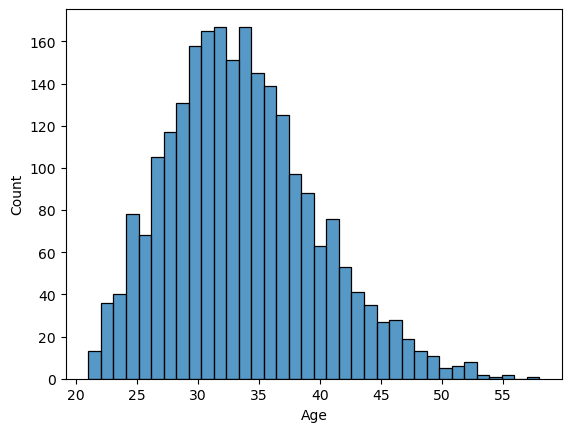

In [39]:
sns.histplot(data=df_grouped,x='Age')

Majority of driver are in the age group of 30 - 35

In [40]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   object        
 1   MMM-YY                2381 non-null   datetime64[ns]
 2   Age                   2381 non-null   float64       
 3   Gender                2381 non-null   float64       
 4   City                  2381 non-null   object        
 5   Education_Level       2381 non-null   float64       
 6   Income                2381 non-null   float64       
 7   Dateofjoining         2381 non-null   datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   2381 non-null   float64       
 10  Grade                 2381 non-null   float64       
 11  Total Business Value  2381 non-null   float64       
 12  Quarterly Rating      2381 non-null   float64       
 13  quarterly_rating_i

In [41]:
#Data type conversions

df_grouped['Gender']=df_grouped['Gender'].astype('str')
df_grouped['Education_Level']=df_grouped['Education_Level'].astype('str')
df_grouped['Joining Designation']=df_grouped['Joining Designation'].astype('str')
df_grouped['Grade']=df_grouped['Grade'].astype('str')
df_grouped['Quarterly Rating']=df_grouped['Quarterly Rating'].astype('str')
df_grouped['quarterly_rating_imp']=df_grouped['quarterly_rating_imp'].astype('str')
df_grouped['income_imp']=df_grouped['income_imp'].astype('str')

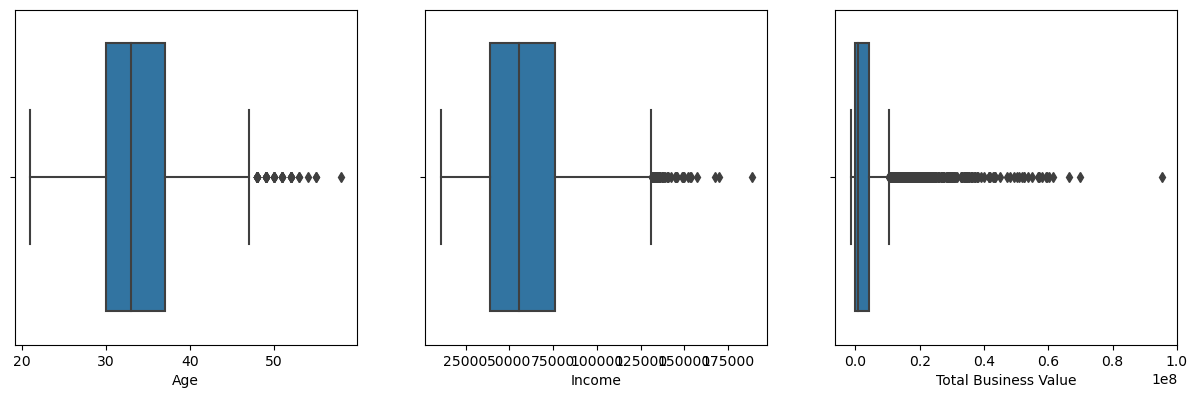

In [42]:
#Select the columns where no of unique values are more than 10 
#assuming that those having less than 10 will behave like a categorical data

cols_=[]
for i in df_grouped.select_dtypes(exclude=['datetime64[ns]','object']).columns:
    if df_grouped[i].nunique()>=5:
        cols_.append(i)  

# Box plots of columns

plt.figure(figsize=(15, 20))

for i in range(1,len(cols_)+1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=cols_[i-1], data=df_grouped)


There are outliers present

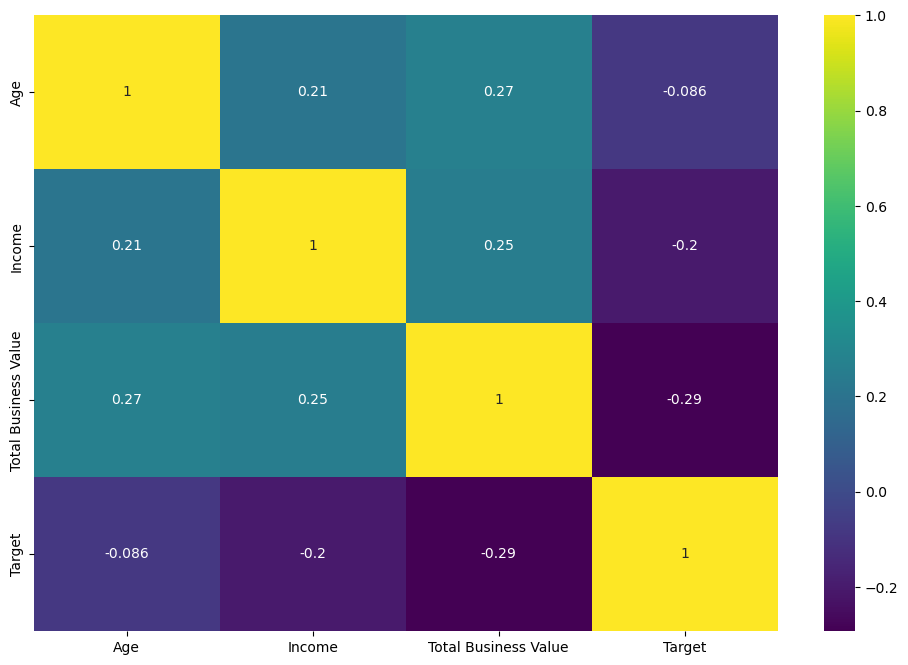

In [43]:
#Correlation heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(df_grouped.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

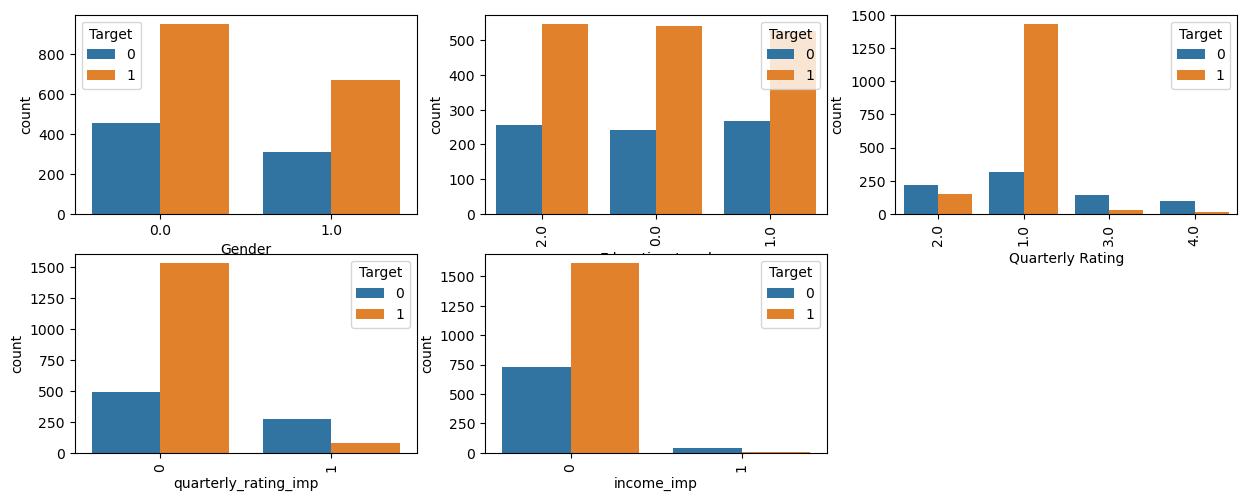

In [44]:
# term / home ownership / verification status / purpose vs loan_status

plt.figure(figsize=(15, 15))

plt.subplot(5, 3, 1)
sns.countplot(x='Gender', data=df_grouped, hue='Target')

plt.subplot(5, 3, 2)
g = sns.countplot(x='Education_Level', data=df_grouped, hue='Target')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(5, 3, 3)
g = sns.countplot(x='Quarterly Rating', data=df_grouped, hue='Target')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(5, 3, 4)
g = sns.countplot(x='quarterly_rating_imp', data=df_grouped, hue='Target')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(5, 3, 5)
g = sns.countplot(x='income_imp', data=df_grouped, hue='Target')
g.set_xticklabels(g.get_xticklabels(), rotation=90);



* Both females and males are having similar proportions of churn where the no of people not churned is 50% of the number of people churned
* Education level is not playing a major role in the churn analysis. Hypothesis testing will be done to confirm the statement
* Those with quarterly rating = 1.0 are the people who churned more
* There are more churns when there is no improvement in the quarterly ratings & income

In [45]:
df_grouped.columns

Index(['Driver_ID', 'MMM-YY', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating',
       'quarterly_rating_imp', 'income_imp', 'Target'],
      dtype='object')

### DATA PREPROCESSING

In [46]:
#Keeping a copy of the grouped dataset and all the preprocessing will be done in the copied dataset

df_pro = df_grouped.copy()

**Update driver_id, MMM-YY column**

'Driver_id' and 'MMM-YY' columns are removed since it doesnt add any value in the model

In [47]:
df_pro.drop(['Driver_ID','MMM-YY'],axis=1,inplace=True)

**Update Age column**

In [48]:
df_pro['Age'].value_counts().head()

32.0    167
34.0    167
31.0    165
30.0    158
33.0    151
Name: Age, dtype: int64

In [49]:
# Hypothesis testing ( t-test ) to check statistical significance of Age on predicting the target feature

a=df_pro[df_pro['Target']==0]['Age']
b=df_pro[df_pro['Target']==1]['Age']

t_stat,p_val = ttest_ind(a,b)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
8.126795311026695e-05


**Update Gender column**

In [50]:
df_pro['Gender'].value_counts()

0.0    1403
1.0     978
Name: Gender, dtype: int64

In [51]:
#crosstab for hypothesis testing ( Chisquare )

b=pd.crosstab(index=df_pro['Gender'],columns=df_pro['Target'])
b

Target,0,1
Gender,,
0.0,455,948
1.0,310,668


In [52]:
#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(b)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is not significant
0.7396634124788158


In [53]:
# Gender column is removed since it is not statistically significant

df_pro.drop('Gender',axis=1,inplace=True)

#Perform onehotencoding

df = pd.get_dummies(df, columns=['grade'], drop_first=True)

**Update City column**

In [54]:
df_pro['City'].value_counts().head()

C20    152
C15    101
C29     96
C26     93
C8      89
Name: City, dtype: int64

In [55]:
df_pro['City'].nunique()

29

In [56]:
#crosstab for hypothesis testing ( Chisquare )

c=pd.crosstab(index=df_pro['City'],columns=df_pro['Target'])
c

Target,0,1
City,,
C1,24,56
C10,25,61
C11,19,45
C12,28,53
C13,13,58
C14,21,58
C15,32,69
C16,34,50
C17,16,55


In [57]:
#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(c)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
0.013977549937173567


tar = TargetEncoder()
df_pro['City'] = tar.fit_transform(df_pro['City'],df_pro['Target'])

**Update Education_Level column**

In [58]:
df_pro['Education_Level'].value_counts()

2.0    802
1.0    795
0.0    784
Name: Education_Level, dtype: int64

In [59]:
#crosstab for hypothesis testing ( Chisquare )

d=pd.crosstab(index=df_pro['Education_Level'],columns=df_pro['Target'])
d

Target,0,1
Education_Level,,
0.0,242,542
1.0,268,527
2.0,255,547


In [60]:
#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(d)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is not significant
0.46643939521309963


In [61]:
# Education_level column is removed since it is not statistically significant

df_pro.drop('Education_Level',axis=1,inplace=True)

**Update Income column**

In [62]:
df_pro['Income'].value_counts().head()

48747.0    3
59644.0    2
12456.0    2
41591.0    2
19072.0    2
Name: Income, dtype: int64

In [63]:
# Hypothesis testing ( t-test ) to check statistical significance of Income on predicting the target feature

a=df_pro[df_pro['Target']==0]['Income']
b=df_pro[df_pro['Target']==1]['Income']

t_stat,p_val = ttest_ind(a,b)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
2.495387415200701e-23


**Update Dateofjoining column**

In [64]:
df_pro['Dateofjoining'].value_counts()

2020-07-31    31
2020-09-28    30
2020-05-29    20
2019-10-31    18
2020-05-01    17
              ..
2018-02-19     1
2016-06-03     1
2017-11-26     1
2019-04-07     1
2017-10-21     1
Name: Dateofjoining, Length: 869, dtype: int64

In [65]:
# Only month values are taken for modelling

df_pro['monthofjoining'] = df_pro['Dateofjoining'].dt.month
df_pro['monthofjoining']=df_pro['monthofjoining'].astype('str')

# Remove Dateofjoining column

df_pro.drop(['Dateofjoining'],axis=1,inplace=True)

In [66]:
#crosstab for hypothesis testing ( Chisquare )

d=pd.crosstab(index=df_pro['monthofjoining'],columns=df_pro['Target'])
d

Target,0,1
monthofjoining,,
1,32,132
10,87,182
11,100,153
12,88,122
2,18,58
3,9,48
4,34,70
5,69,207
6,57,173


In [67]:
#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(d)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
1.6242862540266907e-08


tar = TargetEncoder()
df_pro['monthofjoining'] = tar.fit_transform(df_pro['monthofjoining'],df_pro['Target'])

**Update LastWorkingDate column**

LastWorkingDate column is removed since it doesnt add any value in the model and target feature is already created based on Lastworkingdate column

In [68]:
df_pro.drop(['LastWorkingDate'],axis=1,inplace=True)

**Update Joining Designation column**

In [69]:
df_pro['Joining Designation'].value_counts()

1.0    1026
2.0     815
3.0     493
4.0      36
5.0      11
Name: Joining Designation, dtype: int64

In [70]:
#crosstab for hypothesis testing ( Chisquare )

d=pd.crosstab(index=df_pro['Joining Designation'],columns=df_pro['Target'])
d

Target,0,1
Joining Designation,,
1.0,274,752
2.0,255,560
3.0,219,274
4.0,14,22
5.0,3,8


In [71]:
#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(d)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
5.457615375535053e-10


#Perform onehotencoding

df_pro = pd.get_dummies(df_pro, columns=['Joining Designation'], drop_first=True)

**Update Grade column**

In [72]:
df_pro['Grade'].value_counts()

2.0    855
1.0    741
3.0    623
4.0    138
5.0     24
Name: Grade, dtype: int64

In [73]:
#crosstab for hypothesis testing ( Chisquare )

d=pd.crosstab(index=df_pro['Grade'],columns=df_pro['Target'])

#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(d)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
2.8955519930847994e-27


#Perform onehotencoding

df_pro = pd.get_dummies(df_pro, columns=['Grade'], drop_first=True)

**Update Total Business Value column**

In [74]:
df_pro['Total Business Value'].value_counts()

0.0          719
200000.0      10
250000.0       6
350000.0       5
600000.0       4
            ... 
101980.0       1
4169060.0      1
2590880.0      1
1533680.0      1
1908000.0      1
Name: Total Business Value, Length: 1629, dtype: int64

In [75]:
# Hypothesis testing ( t-test ) to check statistical significance of Income on predicting the target feature

a=df_pro[df_pro['Target']==0]['Total Business Value']
b=df_pro[df_pro['Target']==1]['Total Business Value']

t_stat,p_val = ttest_ind(a,b)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
1.8835484427348198e-82


**Update Quarterly Rating column**

In [76]:
df_pro['Quarterly Rating'].value_counts()

1.0    1744
2.0     362
3.0     168
4.0     107
Name: Quarterly Rating, dtype: int64

In [77]:
#crosstab for hypothesis testing ( Chisquare )

d=pd.crosstab(index=df_pro['Quarterly Rating'],columns=df_pro['Target'])

#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(d)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
2.5289656594512383e-142


#Perform onehotencoding

df_pro = pd.get_dummies(df_pro, columns=['Quarterly Rating'], drop_first=True)

**Update quarterly_rating_imp column**

In [78]:
df_pro['quarterly_rating_imp'].value_counts()

0    2023
1     358
Name: quarterly_rating_imp, dtype: int64

In [79]:
#crosstab for hypothesis testing ( Chisquare )

d=pd.crosstab(index=df_pro['quarterly_rating_imp'],columns=df_pro['Target'])

#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(d)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
1.98105039845764e-86


#Perform onehotencoding

df_pro = pd.get_dummies(df_pro, columns=['quarterly_rating_imp'], drop_first=True)

**Update income_imp column**

In [80]:
df_pro['income_imp'].value_counts()

0    2338
1      43
Name: income_imp, dtype: int64

In [81]:
#crosstab for hypothesis testing ( Chisquare )

d=pd.crosstab(index=df_pro['income_imp'],columns=df_pro['Target'])

#Chisquare test

chi_stat,p_val,dof,expected_val=chi2_contingency(d)

if p_val<0.05:
    print('The feature is significant')
    print(p_val)
else:
    print('The feature is not significant')
    print(p_val)

The feature is significant
2.5729990685015372e-17


#Perform onehotencoding

df_pro = pd.get_dummies(df_pro, columns=['income_imp'], drop_first=True)

In [82]:
df_pro.shape

(2381, 11)

### DATA PREPARATION FOR MODELLING

In [402]:
X = df_pro.drop('Target', axis=1)
y = df_pro['Target']

#### MinMaxScaler -

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [403]:
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)

In [404]:
X_sc = pd.DataFrame(X_sc,columns=X.columns)

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.30,
                                                    stratify=y, random_state=42)

In [406]:
print(X_train.shape)
print(X_test.shape)

(1666, 18)
(715, 18)


In [407]:
y_train.value_counts()

1    1131
0     535
Name: Target, dtype: int64

### REBALANCE THE IMBALANCED DATA USING SMOTE

In [408]:
smt=SMOTE()
X_train_sm,y_train_sm=smt.fit_resample(X_train,y_train)

In [409]:
y_train_sm.value_counts()

1    1131
0    1131
Name: Target, dtype: int64

### LOGISTIC REGRESSION - BASE MODEL

#### MODEL FITTING

In [410]:
logreg = LogisticRegression()
logreg.fit(X_train_sm, y_train_sm)

LogisticRegression()

#### CROSS VALIDATION

In [411]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(logreg,X_train_sm, y_train_sm,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.8        0.82876712 0.82724252 0.77314815 0.        ]
Mean Cross Validation Score : 0.6458315592705526


#### HYPER PARAMETER TUNING

In [412]:
param = {'C':[3,4,5,6,7,10],'penalty':['l2','l1'],'max_iter':[10,20,25,50]}
c = GridSearchCV(logreg,param,cv=cv,scoring='f1')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'C': 7, 'max_iter': 20, 'penalty': 'l2'}
The score is : 0.8661506512621591


### LOGISTIC REGRESSION - TUNED MODEL

#### MODEL FITTING

In [413]:
logreg = LogisticRegression(C=7,max_iter=20,penalty='l2')
logreg.fit(X_train_sm, y_train_sm)

LogisticRegression(C=7, max_iter=20)

#### CROSS VALIDATION

In [414]:
cross_score=cross_val_score(logreg,X_train_sm, y_train_sm,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.79581152 0.82556131 0.82943144 0.77598152 0.        ]
Mean Cross Validation Score : 0.6453571586618129


#### METRIC EVALUATION ON TEST DATA

In [415]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.789


#### Confusion Matrix -

In [416]:
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)

[[174  56]
 [ 95 390]]


#### Classification Report -

In [417]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       230
           1       0.87      0.80      0.84       485

    accuracy                           0.79       715
   macro avg       0.76      0.78      0.77       715
weighted avg       0.80      0.79      0.79       715



### ROC CURVE

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

- TPR=(TP)/(TP+FN)

False Positive Rate (FPR) is defined as follows:

- FPR=(FP)/(FP+TN)

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

### AUC (AREA UNDER CURVE)

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).


AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:

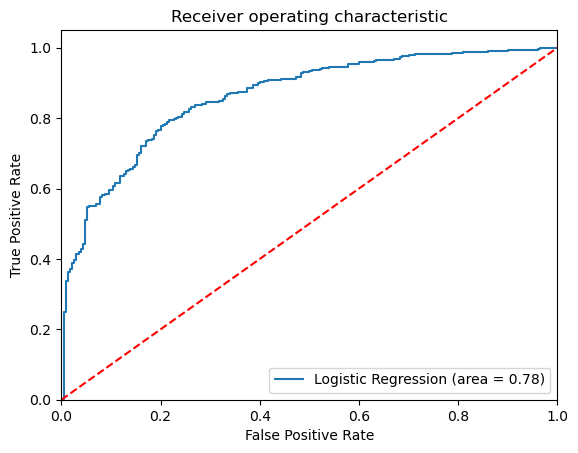

In [418]:
roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

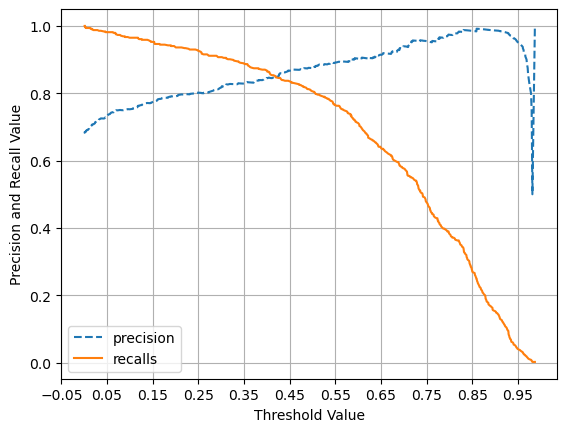

In [419]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, logreg.predict_proba(X_test)[:,1])

### RANDOM FOREST CLASSIFIER - BASE MODEL

#### MODEL FITTING

In [420]:
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

#### CROSS VALIDATION

In [421]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(rf,X_train_sm, y_train_sm,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.85178876 0.88026981 0.88244767 0.84466019 0.        ]
Mean Cross Validation Score : 0.6918332860244127


#### HYPER PARAMETER TUNING

In [422]:
param = {'max_depth':[10,20,50], 'n_estimators':[50,100], 'criterion':['gini','entropy'],
        'max_features':['auto','sqrt','log2']}
c = GridSearchCV(rf,param,cv=cv,scoring='f1')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
The score is : 0.8783372476261484


### RANDOM FOREST CLASSIFIER - TUNED MODEL

#### MODEL FITTING

In [423]:
rf = RandomForestClassifier(criterion='gini',max_depth=20, max_features ='sqrt',n_estimators= 100)
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=20, max_features='sqrt')

#### CROSS VALIDATION

In [424]:
cross_score=cross_val_score(rf,X_train_sm, y_train_sm,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.85616438 0.88175676 0.88492707 0.84134615 0.        ]
Mean Cross Validation Score : 0.6928388721230243


#### METRIC EVALUATION ON TEST DATA

In [425]:
y_pred = rf.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(rf.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.806


#### Confusion Matrix -

In [426]:
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)

[[168  62]
 [ 77 408]]


#### Classification Report -

In [427]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       230
           1       0.87      0.84      0.85       485

    accuracy                           0.81       715
   macro avg       0.78      0.79      0.78       715
weighted avg       0.81      0.81      0.81       715



### ROC CURVE

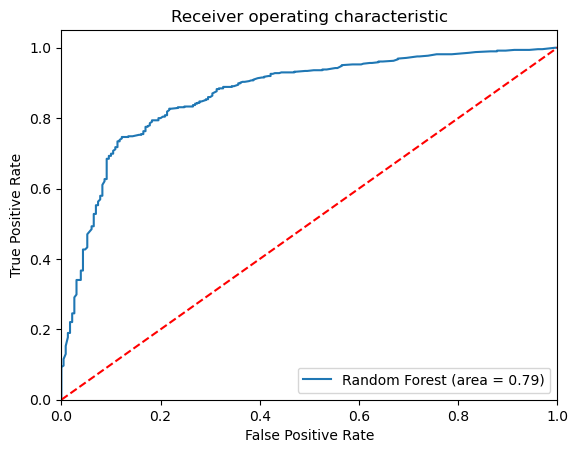

In [428]:
roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

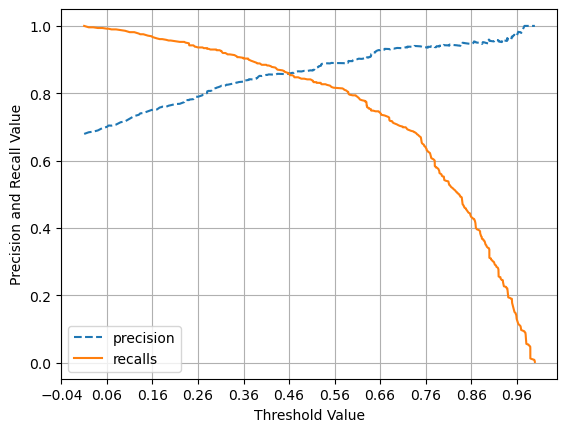

In [429]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, rf.predict_proba(X_test)[:,1])

### XGBOOST CLASSIFIER - BASE MODEL

#### MODEL FITTING

In [430]:
xgb = XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### CROSS VALIDATION

In [431]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(xgb,X_train_sm, y_train_sm,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.83445946 0.87248322 0.88467615 0.84596577 0.        ]
Mean Cross Validation Score : 0.6875169192893542


#### HYPER PARAMETER TUNING

In [432]:
param = {'max_depth':[10,20,50], 'n_estimators':[50,100], 'criterion':['gini','entropy'],
        'max_features':['auto','sqrt','log2']}
c = GridSearchCV(xgb,param,cv=cv,scoring='f1')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
The score is : 0.8645457892127986


### XGBOOST CLASSIFIER - TUNED MODEL

#### MODEL FITTING

In [433]:
rf = RandomForestClassifier(criterion='gini',max_depth=20, max_features ='auto',n_estimators= 100)
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=20)

#### CROSS VALIDATION

In [434]:
cross_score=cross_val_score(rf,X_train_sm, y_train_sm,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.85519591 0.8836425  0.87254902 0.83373494 0.        ]
Mean Cross Validation Score : 0.6890244733129994


#### METRIC EVALUATION ON TEST DATA

In [435]:
y_pred = rf.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(xgb.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.808


#### Confusion Matrix -

In [436]:
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)

[[173  57]
 [ 73 412]]


#### Classification Report -

In [437]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.75      0.73       230
           1       0.88      0.85      0.86       485

    accuracy                           0.82       715
   macro avg       0.79      0.80      0.80       715
weighted avg       0.82      0.82      0.82       715



### ROC CURVE

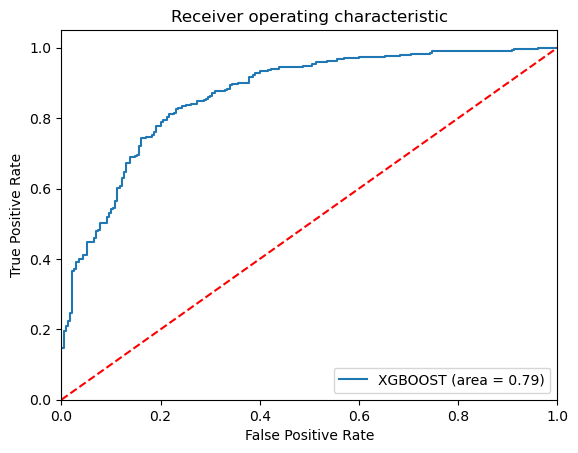

In [438]:
roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBOOST (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

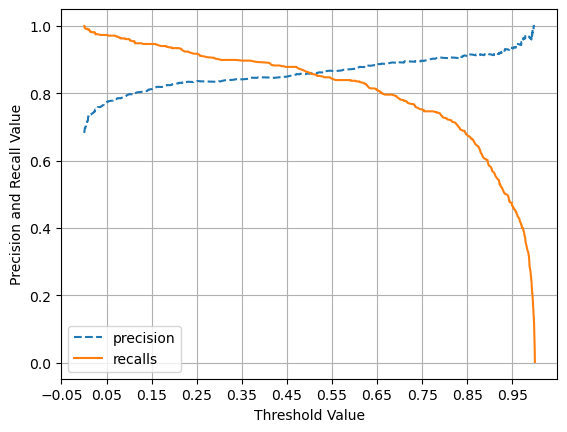

In [439]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, xgb.predict_proba(X_test)[:,1])

### SUMMARIZE MODEL PERFORMANCE

**LOGISTIC REGRESSION**<br>
Accuracy : 0.789<br>
Precision : 0.87<br>
Recall : 0.80<br>
F1 Score : 0.84<br>
AUC ROC : 0.78<br><br>
**RANDOM FOREST**<br>
Accuracy : 0.806<br>
Precision : 0.87<br>
Recall : 0.84<br>
F1 Score : 0.85<br>
AUC ROC : 0.79<br><br>
**XGBOOST**<br>
Accuracy : 0.808<br>
Precision : 0.86<br>
Recall : 0.85<br>
F1 Score : 0.86<br>
AUC ROC : 0.79

XGBOOST is performing better compared to other models

### FEATURE IMPORTANCES

In [440]:
fi = pd.DataFrame()
fi['Coefficients'] = xgb.feature_importances_.reshape(-1,)
fi['Features'] = X_train.columns
fi.sort_values(by='Coefficients', ascending=False,inplace=True)
fi

,Coefficients,Features
16,0.420200,quarterly_rating_imp_1
6,0.113582,Joining Designation_3.0
3,0.054402,Total Business Value
13,0.051953,Quarterly Rating_2.0
14,0.051239,Quarterly Rating_3.0
4,0.047718,monthofjoining
7,0.045053,Joining Designation_4.0
11,0.037136,Grade_4.0
15,0.033822,Quarterly Rating_4.0
0,0.028543,Age


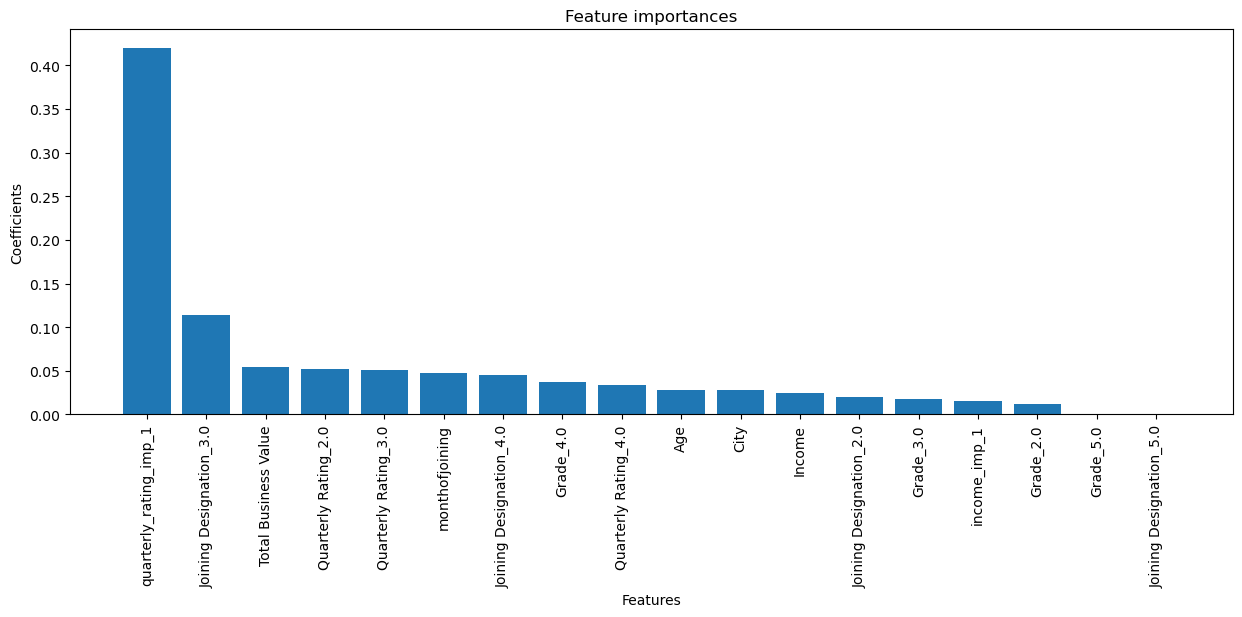

In [441]:
plt.figure(figsize=(15,5))
plt.bar(x=fi['Features'], height=fi['Coefficients'])
plt.xticks(rotation=90)
plt.title('Feature importances')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

### INSIGHTS AND RECOMMENDATIONS

* Quarterly rating is an important feature affecting the churn
* Drivers with a quarterly rating of 1 is more likely to churn
* There are more churns when there is no improvement in the quarterly ratings & income
* To reduce churn, quarterly rating should be more than 3
* 11 features of the driver are relevant for the churn prediction
* Majority of the drivers are in the age group of 30 - 35
* Both females and males are having similar proportions of churn where the no of people not churned is 50% of the number of people churned
* Education level is not playing a major role in the churn analysis. Hypothesis testing will be done to confirm the statement
* XGBoost Algorithm performs better than other models with an accuracy of close to 81% and F1 score of 86%